<a href="https://colab.research.google.com/github/86lekwenshiung/Neural-Network-with-Tensorflow/blob/main/05_Transfer_Learning_with_Tensorflow_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Transfer Learning with Tensorflow Part 2 : Fine Tuning
___

Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

2 main benefits:
  1. Leverage an existing neural network architecture proven to work on similiar , related problems.
  2. Leverage a working neural network architecture which has already learned patterns on similiar pattern on similiar data to our own , then we can adapt those pattern to our own.

<p align = 'center'>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/07-feature-extraction-then-fine-tune.png'>
</p>

### Import Libraries
___


In [141]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import os
import zipfile
import pathlib

### Check GPU
___

In [142]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### General Functions
___

In [143]:
# Refer to Tensorboard Doc String : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
def create_tensorboard_callback(dir_name , experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """

  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  
  print(f'Saving Tensorboard log files to {log_dir}')

  return tensorboard_callback

In [144]:
def plot_loss_curves(history):
  loss = history.history['loss']
  accuracy = history.history['accuracy']

  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize = (12,8))

  #Plot Accuracy
  plt.subplot(1,2,1)
  plt.plot(epochs , loss , label = 'training loss')
  plt.plot(epochs , val_loss , label = 'validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs , accuracy , label = 'training accuracy')
  plt.plot(epochs , val_accuracy , label = 'validation accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()


In [145]:
def compare_loss_curves(history_old , history_new , epochs):
 
  # Define Original History
  loss = history_old.history['loss']
  accuracy = history_old.history['accuracy']

  val_loss = history_old.history['val_loss']
  val_accuracy = history_old.history['val_accuracy']

  # Define New History
  total_loss = loss + history_new.history['loss']
  total_accuracy = accuracy + history_new.history['accuracy']

  total_val_loss = val_loss + history_new.history['val_loss']
  total_val_accuracy = val_accuracy + history_new.history['val_accuracy']  

  plt.figure(figsize = (12,8))

  #Plot Accuracy
  plt.subplot(1,2,1)
  plt.plot(total_loss , label = 'training loss')
  plt.plot(total_val_loss , label = 'validation loss')
  plt.title('Train and Validation Loss')
  plt.xlabel('epochs')
  plt.axvline(x = epochs , 
             label = 'Start Fine Tuning',
             ymin = 0 ,
             ymax = 1,
             color = 'green')    
  plt.legend()

  #Plot Accuracy
  plt.subplot(1,2,2)
  plt.plot(total_accuracy , label = 'training accuracy')
  plt.plot(total_val_accuracy , label = 'validation accuracy')
  plt.title('Train and Validation Accuracy')
  plt.xlabel('epochs')
  plt.axvline(x = epochs , 
             label = 'Start Fine Tuning',
             ymin = 0 ,
             ymax = 1,
             color = 'green')  
  plt.legend()

In [146]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(filenames)} files and {len(dirnames)} in {dirpath}')

In [147]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

#1.0 Getting Data from Food101
___

Using pretrained model within tf.keras.application and applt them to our own food images.
Source : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [148]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

--2021-09-08 14:02:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 142.250.157.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   125MB/s    in 1.3s    

2021-09-08 14:02:45 (125 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [149]:
# Unzip Data
unzip_data('10_food_classes_10_percent.zip')

###1.1 Exploring File Path
___

In [150]:
walk_through_dir('10_food_classes_10_percent')

There are 0 files and 2 in 10_food_classes_10_percent
There are 0 files and 10 in 10_food_classes_10_percent/train
There are 75 files and 0 in 10_food_classes_10_percent/train/chicken_curry
There are 75 files and 0 in 10_food_classes_10_percent/train/fried_rice
There are 75 files and 0 in 10_food_classes_10_percent/train/steak
There are 75 files and 0 in 10_food_classes_10_percent/train/pizza
There are 75 files and 0 in 10_food_classes_10_percent/train/ramen
There are 75 files and 0 in 10_food_classes_10_percent/train/hamburger
There are 75 files and 0 in 10_food_classes_10_percent/train/ice_cream
There are 75 files and 0 in 10_food_classes_10_percent/train/grilled_salmon
There are 75 files and 0 in 10_food_classes_10_percent/train/sushi
There are 75 files and 0 in 10_food_classes_10_percent/train/chicken_wings
There are 0 files and 10 in 10_food_classes_10_percent/test
There are 250 files and 0 in 10_food_classes_10_percent/test/chicken_curry
There are 250 files and 0 in 10_food_class

### 1.2 Setting up file path
___

In [151]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

### 1.3 Setting up Class Name
___

In [152]:
data_dir = pathlib.Path(train_dir)

for item in data_dir.glob('*'):
  print(item.name)

chicken_curry
fried_rice
steak
pizza
ramen
hamburger
ice_cream
grilled_salmon
sushi
chicken_wings


In [153]:
class_name = [item.name for item in data_dir.glob('*')]
class_name

['chicken_curry',
 'fried_rice',
 'steak',
 'pizza',
 'ramen',
 'hamburger',
 'ice_cream',
 'grilled_salmon',
 'sushi',
 'chicken_wings']

### 1.4 Visualising Data
___

In [154]:
img_size = (224,224)
batch_size = 32

train_data_10_percent = image_dataset_from_directory(directory=train_dir,
                                                     image_size = img_size,
                                                     label_mode = 'categorical',
                                                     batch_size = batch_size)

test_data_10_percent = image_dataset_from_directory(directory = test_dir,
                                                    image_size = img_size,
                                                    label_mode = 'categorical',
                                                    batch_size = batch_size)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [155]:
# Create batches of 32 images of pixel size 224, 244, splitting into red , green , blue color channels
# 2 array of (images , labels)
print(test_data_10_percent)

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>


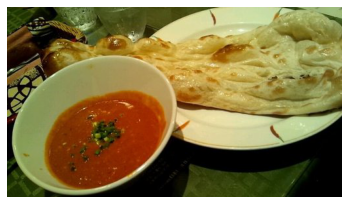

In [156]:
sample_path = '/content/10_food_classes_10_percent/train/chicken_curry/'
random_image = sample_path + '/' + random.choice(os.listdir(sample_path))

img = plt.imread(random_image)
plt.axis(False)
plt.imshow(img);

In [157]:
def view_random_image(target_class , target_path):
  sample_path = target_path + '/' + target_class
  random_image = sample_path + '/' + random.choice(os.listdir(sample_path))

  img = plt.imread(random_image)
  plt.imshow(img)
  plt.axis(False)
  plt.title(f'{target_class} , {img.shape}')


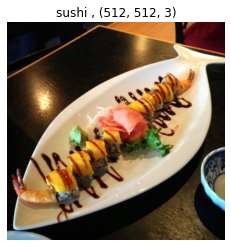

In [158]:
view_random_image(target_class ='sushi',
                  target_path = '/content/10_food_classes_10_percent/train')

#### 1.4.1 Alternative method to get Class Name
___

In [159]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### 1.5 Understanding Feature Vector and Effect of GlobalAverage2D
___

<p align = 'center'>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/06-efficientnetb0-feature-extractor-with-dense-layer-on-top.png'>
</p>

In [160]:
# GlobalMaxPooling2D get the largest value inside each corresponding array and return them into the reduced array.
# GlobalAveragePooling2D get the mean value inside each corresponding array and return them into the reduced array
# Input Shape
input_shape = (1,4,4,3)

# Create a random tensor
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a gloabl average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f'2D Avaerage pool 2D tensor:\n {global_average_pooled_tensor}\n')

print(f'Input tensor shape:\n {input_tensor.shape}\n')
print(f'Average pool 2D shape:\n {global_average_pooled_tensor.shape}\n')

Random input tensor:
 [[[[ 1.3362467  -1.6971288   0.77623373]
   [ 0.37503627 -0.3215587   0.38511974]
   [-1.0999154  -1.5079926  -0.75078326]
   [-0.38371655 -0.6962863  -0.9699295 ]]

  [[ 0.36509892 -1.2239707   0.99395734]
   [-0.85319936  0.36634195 -0.5926016 ]
   [ 0.9740157   0.3534583   0.77759933]
   [-0.9885874   1.7108924  -0.298414  ]]

  [[-1.976025    0.25890592  0.5063229 ]
   [ 0.5186663  -0.8270432  -1.6014638 ]
   [ 0.9903114  -0.43310082 -0.26455098]
   [-1.4609945   0.4665586   2.3475425 ]]

  [[ 1.4460207  -0.523542    0.49988848]
   [ 0.54037684 -1.9139837  -0.46440277]
   [ 1.2226529   0.94038033 -1.9342576 ]
   [ 1.2352713  -0.7370712   0.11476211]]]]

2D Avaerage pool 2D tensor:
 [[1.4460207 1.7108924 2.3475425]]

Input tensor shape:
 (1, 4, 4, 3)

Average pool 2D shape:
 (1, 3)



#### 1.5.1 Replicating Global Average 2D Tensor Manually
___

In [161]:
tf.reduce_mean(input_tensor , axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.14007866, -0.36157125, -0.02968608]], dtype=float32)>

### 2.0 Model 0 :Baseline Model with Functional API
___

|Experiment|Data|Preprocessing|Model|
|---|---|---|---|
|Model 0|10 classes of Food101 data at 10%| None|Feature Extractor : EfficientNet B0|
|Model 1|10 classes of Food101 data at 1%|Random Flip, Rotation n, Augmentation|EfficientNetB0|
|Model 2|Same as Model 0|Same as Model 1|EfficientNetB0|
|Model 3|Same as Model 0|Same as Model 1| Fine tuning: EfficientNetB0 with top layers trained on custom data , top 10 layers unfrozen|
|Model 4|10 classes of Food101 data at 100%| Same as Model 1|Same as Model 3|

In [162]:
# Create Model 1 with functional API : https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

# Step 1 
efficientnetb0 = tf.keras.applications.EfficientNetB0(include_top = False)

# Step 2 : Freeze the base model
efficientnetb0.trainable = False

# Step 3 : Create Input Layers
inputs = tf.keras.layers.Input(shape = (224,224,3) , name = 'input_layer')

# Rescaling : EfficientNet has a pre-build pre-scale function

# Step 5: Feed input into model
x = efficientnetb0(inputs)
print(f'Shape of Model {x.shape}')

# # Step 6: Average Pool the model before output
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pool')(x)
print(f'Shape of Model after Passing through Average pool {x.shape}')

# Step 7: Create Output layer
outputs = tf.keras.layers.Dense(10 , activation = 'softmax' , name = 'output_layers')(x)
print(f'Output Shape : {outputs.shape}')

# Step 8: Average Pool the model before output
model_0 = tf.keras.Model(inputs , outputs)

Shape of Model (None, 7, 7, 1280)
Shape of Model after Passing through Average pool (None, 1280)
Output Shape : (None, 10)


In [163]:
# Fitting the Model

model_0.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = 'accuracy')

history_0 = model_0.fit(train_data_10_percent, 
                        epochs = 5,
                        callbacks = create_tensorboard_callback(dir_name = 'save_dir',
                                                                  experiment_name = 'model_0'),
                        validation_data = test_data_10_percent,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_steps = len(test_data_10_percent))

Saving Tensorboard log files to save_dir/model_0/20210908-140253
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 23s 678ms/step - loss: 1.9278 - accuracy: 0.3960 - val_loss: 1.3895 - val_accuracy: 0.6764
Epoch 2/5
24/24 [==============================] - 14s 576ms/step - loss: 1.1656 - accuracy: 0.7293 - val_loss: 0.9532 - val_accuracy: 0.7872
Epoch 3/5
24/24 [==============================] - 14s 576ms/step - loss: 0.8518 - accuracy: 0.7987 - val_loss: 0.7658 - val_accuracy: 0.8196
Epoch 4/5
24/24 [==============================] - 14s 574ms/step - loss: 0.6962 - accuracy: 0.8480 - val_loss: 0.6742 - val_accuracy: 0.8336
Epoch 5/5
24/24 [==============================] - 14s 572ms/step - loss: 0.5990 - accuracy: 0.8613 - val_loss: 0.6196 - val_accuracy: 0.8404


#### 2.1 Visualing Model Layers from EfficientNetB0
___

In [164]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 129ms/step - loss: 0.6196 - accuracy: 0.8404


[0.6195666790008545, 0.840399980545044]

In [165]:
for layer_number , layer in enumerate(model_0.layers):
  print(layer_number , layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pool
3 output_layers


In [166]:
model_0.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool (GlobalA (None, 1280)              0         
_________________________________________________________________
output_layers (Dense)        (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [167]:
for layer_number , layer in enumerate(efficientnetb0.layers):
  print(layer_number , layer.name)

0 input_18
1 rescaling_17
2 normalization_17
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3

In [168]:
efficientnetb0.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_17 (Rescaling)        (None, None, None, 3 0           input_18[0][0]                   
__________________________________________________________________________________________________
normalization_17 (Normalization (None, None, None, 3 7           rescaling_17[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_17[0][0]           
_____________________________________________________________________________________

#### 2.2 Visualing Loss Curves
___

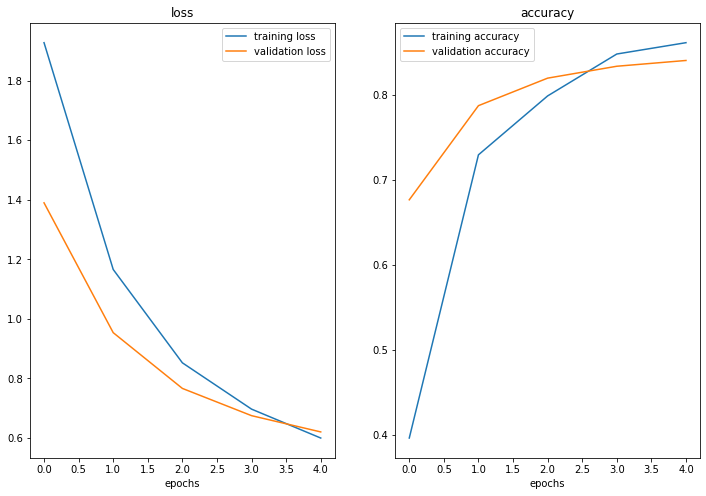

In [169]:
plot_loss_curves(history_0)

### 3.0 Model 1 : feature Extraction with 1% Dataset with Data Augmentation
___

In [170]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip 

--2021-09-08 14:04:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   103MB/s    in 1.2s    

2021-09-08 14:04:46 (103 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [171]:
# Unzip Data
unzip_data('10_food_classes_1_percent.zip')

In [172]:
# Exploring File Path
walk_through_dir('10_food_classes_1_percent')

There are 0 files and 2 in 10_food_classes_1_percent
There are 0 files and 10 in 10_food_classes_1_percent/train
There are 7 files and 0 in 10_food_classes_1_percent/train/chicken_curry
There are 7 files and 0 in 10_food_classes_1_percent/train/fried_rice
There are 7 files and 0 in 10_food_classes_1_percent/train/steak
There are 7 files and 0 in 10_food_classes_1_percent/train/pizza
There are 7 files and 0 in 10_food_classes_1_percent/train/ramen
There are 7 files and 0 in 10_food_classes_1_percent/train/hamburger
There are 7 files and 0 in 10_food_classes_1_percent/train/ice_cream
There are 7 files and 0 in 10_food_classes_1_percent/train/grilled_salmon
There are 7 files and 0 in 10_food_classes_1_percent/train/sushi
There are 7 files and 0 in 10_food_classes_1_percent/train/chicken_wings
There are 0 files and 10 in 10_food_classes_1_percent/test
There are 250 files and 0 in 10_food_classes_1_percent/test/chicken_curry
There are 250 files and 0 in 10_food_classes_1_percent/test/fried_

In [173]:
img_size = (224,224)
train_1_percent_dir = '10_food_classes_1_percent/train'
test_1_percent_dir  = '10_food_classes_1_percent/test'

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_1_percent_dir,
                                                                           label_mode = 'categorical',
                                                                           image_size = img_size,
                                                                           batch_size = batch_size)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_1_percent_dir,
                                                                          label_mode = 'categorical',
                                                                          image_size = img_size,
                                                                          batch_size = batch_size)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### 3.1 Visualising Data Augmentation Effect
___

In [174]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

In [175]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

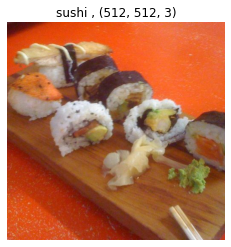

In [176]:
view_random_image(target_class = 'sushi' , target_path=train_1_percent_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


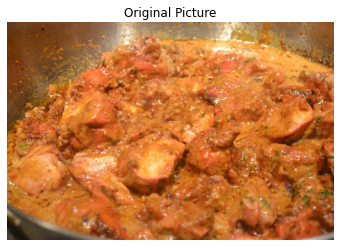

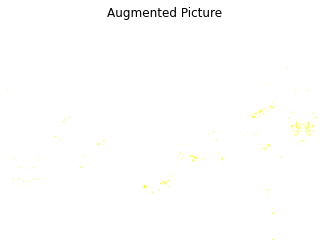

In [177]:
# Augmentated Data is not normalised , therefore the effect shown below
sample_path = '/content/10_food_classes_10_percent/train/chicken_curry/'
random_image = sample_path + '/' + random.choice(os.listdir(sample_path))

img = plt.imread(random_image)
aug_img = data_augmentation(img)

plt.imshow(img)
plt.title(f'Original Picture')
plt.axis(False)

plt.figure()
plt.imshow(aug_img)
plt.title(f'Augmented Picture')
plt.axis(False);

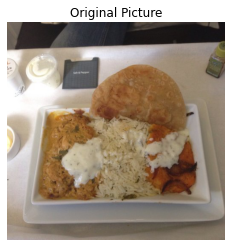

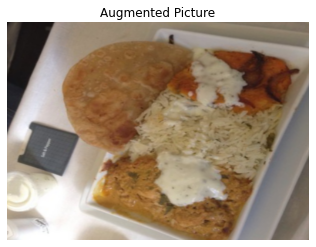

In [178]:
# Augmentated Data after rescaling
sample_path = '/content/10_food_classes_10_percent/train/chicken_curry/'
random_image = sample_path + '/' + random.choice(os.listdir(sample_path))

img = plt.imread(random_image)
aug_img = data_augmentation(img)

plt.imshow(img)
plt.title(f'Original Picture')
plt.axis(False)

plt.figure()
plt.imshow(tf.squeeze(aug_img/255))
plt.title(f'Augmented Picture')
plt.axis(False);

#### 3.2 Creating Model 1
___

In [179]:
# Call in Fuctional API

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Input layers
inputs = tf.keras.layers.Input(shape = (224,224 , 3) , name = 'input_layer')

# Data Augmentation
x = data_augmentation(inputs)

# Create a frozen base model
x = base_model(x , training = False)

# Global Average Pool the features
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Output Layer
outputs = tf.keras.layers.Dense(10 , activation = 'softmax' , name = 'output_layer')(x)

#Create model 1
model_1 = tf.keras.Model(inputs , outputs)

In [180]:
# Compile the model

model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                metrics = 'accuracy',
                loss = tf.keras.losses.CategoricalCrossentropy())

#Fitting the Model
history_1 = model_1.fit(train_data_1_percent,
                        epochs = 5,
                        callbacks = create_tensorboard_callback(dir_name = 'save_dir',
                                                                  experiment_name = 'model_1'),
                        validation_data = test_data_1_percent,
                        steps_per_epoch = len(train_data_1_percent),
                        validation_steps = len(test_data_1_percent))

Saving Tensorboard log files to save_dir/model_1/20210908-140452
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 20s 7s/step - loss: 2.3692 - accuracy: 0.1429 - val_loss: 2.2698 - val_accuracy: 0.1968
Epoch 2/5
3/3 [==============================] - 11s 5s/step - loss: 2.1403 - accuracy: 0.3429 - val_loss: 2.1479 - val_accuracy: 0.2616
Epoch 3/5
3/3 [==============================] - 11s 5s/step - loss: 1.9939 - accuracy: 0.3429 - val_loss: 2.0406 - val_accuracy: 0.3124
Epoch 4/5
3/3 [==============================] - 11s 5s/step - loss: 1.7838 - accuracy: 0.4429 - val_loss: 1.9458 - val_accuracy: 0.3692
Epoch 5/5
3/3 [==============================] - 11s 5s/step - loss: 1.6707 - accuracy: 0.5571 - val_loss: 1.8593 - val_accuracy: 0.4212


In [181]:
model_1.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, 3)           0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


#### 3.3 Visualising Loss Curves
___

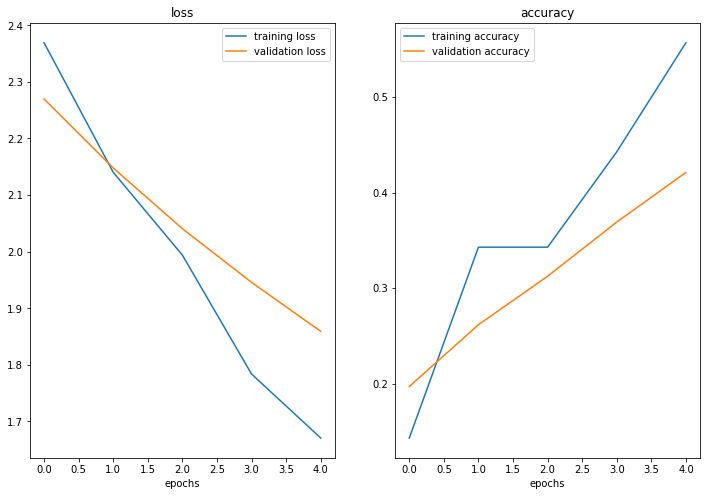

In [182]:
plot_loss_curves(history_1)

### 4.0 Model 2 : Feature Extraction with 10% Dataset with Data Augmentation
___

In [183]:
# Call base model from tf application
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False # pass the images to base model but keep it in inference mode, so that batchnorm statistic don't get updated even after we unfreeze the base

# inputs layer
inputs = tf.keras.layers.Input(shape = (224,224,3) , name = 'input_layer')

# Parse it through Data Aug
x = data_augmentation(inputs)

# Create a frozen Base Model
x = base_model(x , training = False)

# Global Average Pool the model
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# output layer
outputs = tf.keras.layers.Dense(10 , activation  = 'softmax' , name = 'output_layer')(x)

# Create model
model_2 = tf.keras.Model(inputs , outputs)

In [184]:
# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = 'accuracy')


#### 4.1 Create a model checkpointing 
___

- Model checkpoint callback saved our model (the model of weights) during training. This is useful where we long training time so that we can return and start where we left off.
- link : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [185]:
'''
# Example
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
'''


checkpoint_filepath = 'ten_percent_model_checkpoints_weights/checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    save_best_only = False,
    save_freq = 'epoch',
    verbose = True)


# Fitting the Model
history_2 = model_2.fit(train_data_10_percent,
                        epochs = 5,
                        callbacks = [create_tensorboard_callback('save_dir' , 'model_2'), checkpoint_callback],
                        validation_data = test_data_10_percent,
                        validation_steps = len(test_data_10_percent))

Saving Tensorboard log files to save_dir/model_2/20210908-140626
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 28s 898ms/step - loss: 1.9415 - accuracy: 0.3600 - val_loss: 1.4603 - val_accuracy: 0.6508

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 2/5
24/24 [==============================] - 18s 761ms/step - loss: 1.3331 - accuracy: 0.6787 - val_loss: 1.0492 - val_accuracy: 0.7572

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 3/5
24/24 [==============================] - 18s 755ms/step - loss: 1.0474 - accuracy: 0.7413 - val_loss: 0.8523 - val_accuracy: 0.7992

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 4/5
24/24 [==============================] - 18s 732ms/step - loss: 0.8965 - accuracy: 0.7693 - val_loss: 0.7536 - val_accuracy: 0.8132

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 5/5
24/24 [==============================] - 17s 716ms/step - loss: 0.7944 - accuracy: 0.7920 - val_loss: 0.6857 - val_a

In [186]:
model_2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, 3)           0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


#### 4.2 Visualising Loss Curves
___

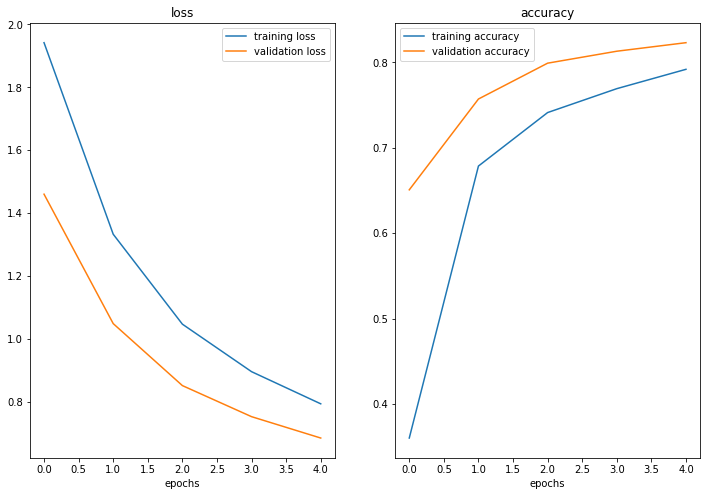

In [187]:
plot_loss_curves(history_2)

#### 4.3 Loading in model weights
___
- The model weights (that are considered the best) are loaded into the model.
- link : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [188]:
print('Original Model 2 Score')
print(model_2.evaluate(test_data_10_percent))
print('----------------------------')

model_2.load_weights(checkpoint_filepath)

print('Loaded Model 2 Score')
print(model_2.evaluate(test_data_10_percent))
print('----------------------------')

Original Model 2 Score
79/79 [==============================] - 11s 128ms/step - loss: 0.6857 - accuracy: 0.8232
[0.6857286095619202, 0.823199987411499]
----------------------------
Loaded Model 2 Score
79/79 [==============================] - 11s 129ms/step - loss: 0.6857 - accuracy: 0.8232
[0.6857286095619202, 0.823199987411499]
----------------------------


### 5.0 Model 3 - Fine Tuning Feature Extraction with 10% Dataset , Data Augmentation
___

Fine tuning work best after training a feature extraction for a few epochs with custom data.

In [189]:
# Accessing our layers in Model 2
for layer in model_2.layers:
  print(layer , layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5c79bed490> True
<keras.engine.sequential.Sequential object at 0x7f5c6f0ed0d0> True
<keras.engine.functional.Functional object at 0x7f5c797766d0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f5c7977e090> True
<keras.layers.core.Dense object at 0x7f5c79736d50> True


In [190]:
# Accessing layers in the functional API 
for index , layer in enumerate(model_2.layers[2].layers[:20]):
  print(index, layer.name , layer.trainable)

0 input_20 False
1 rescaling_19 False
2 normalization_19 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False


In [191]:
# Currently there are 0 trainable layers in our base model because we had frozen the layers in earlier initiatiation

print(len(model_2.layers[2].trainable_variables))

0


#### 5.1 Fine tuning models
____

In [192]:
# Redefine base model
base_model.trainable = True

# Keep All layer in functional API as not trainable, Make last 10 layer trainable
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [193]:
# Double check the layer trainable assignment
print(f' No. of Trainable Layers : {len(base_model.trainable_variables)}')
print(f' Total Layers : {len(base_model.layers)}')

 No. of Trainable Layers : 10
 Total Layers : 237


In [194]:
# Compile the model

model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate during fine tuning
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = 'accuracy')

In [195]:
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

history_3 = model_2.fit(train_data_10_percent,
                        epochs = fine_tune_epochs,
                        validation_data = test_data_10_percent,
                        callbacks = [create_tensorboard_callback('save_dir' , 'model_3') , checkpoint_callback],
                        validation_steps = len(test_data_10_percent),
                        initial_epoch = history_2.epoch[-1]) # continue from previous model where it left off which is at the 5th epoch.

Saving Tensorboard log files to save_dir/model_3/20210908-140844
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 29s 855ms/step - loss: 0.6983 - accuracy: 0.7933 - val_loss: 0.5470 - val_accuracy: 0.8376

Epoch 00005: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 6/10
24/24 [==============================] - 18s 763ms/step - loss: 0.5505 - accuracy: 0.8280 - val_loss: 0.5178 - val_accuracy: 0.8336

Epoch 00006: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 7/10
24/24 [==============================] - 19s 772ms/step - loss: 0.4792 - accuracy: 0.8560 - val_loss: 0.4956 - val_accuracy: 0.8408

Epoch 00007: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 8/10
24/24 [==============================] - 18s 747ms/step - loss: 0.4156 - accuracy: 0.8733 - val_loss: 0.4868 - val_accuracy: 0.8416

Epoch 00008: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 9/10
24/24 [==============================] - 18s 742ms/step - loss: 0.3957 - accuracy: 0.8773 - val_loss: 0.4984 - v

In [196]:
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 128ms/step - loss: 0.4790 - accuracy: 0.8448


[0.4790463447570801, 0.8447999954223633]

#### 5.2 Visualising Loss Curves
___

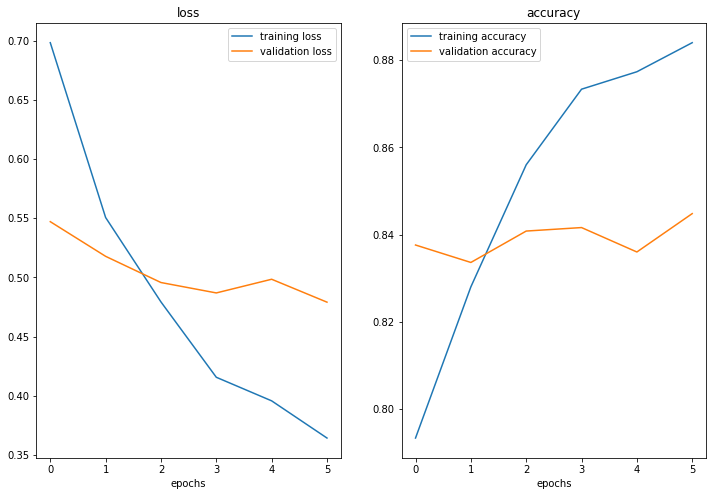

In [197]:
plot_loss_curves(history_3)

#### 5.3 Comparing Before and After Fine Tuned Model
___

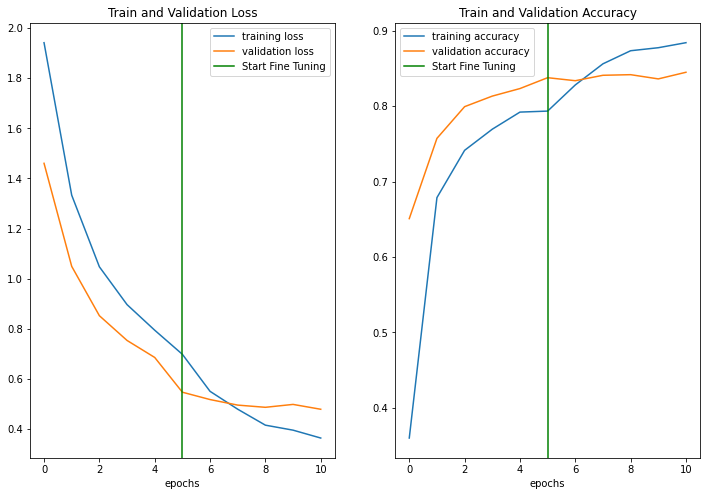

In [198]:
compare_loss_curves(history_2 , history_3 , 5)

### 6.0 Model 4 - Fine Tuning Feature Extraction with 100% Dataset
___

In [199]:
# Load in Data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip Data
unzip_data('10_food_classes_all_data.zip')

--2021-09-08 14:11:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   108MB/s    in 4.9s    

2021-09-08 14:11:27 (102 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



#### 6.1 Exploring File Path
___

In [200]:
walk_through_dir('10_food_classes_all_data')

There are 0 files and 2 in 10_food_classes_all_data
There are 0 files and 10 in 10_food_classes_all_data/train
There are 750 files and 0 in 10_food_classes_all_data/train/chicken_curry
There are 750 files and 0 in 10_food_classes_all_data/train/fried_rice
There are 750 files and 0 in 10_food_classes_all_data/train/steak
There are 750 files and 0 in 10_food_classes_all_data/train/pizza
There are 750 files and 0 in 10_food_classes_all_data/train/ramen
There are 750 files and 0 in 10_food_classes_all_data/train/hamburger
There are 750 files and 0 in 10_food_classes_all_data/train/ice_cream
There are 750 files and 0 in 10_food_classes_all_data/train/grilled_salmon
There are 750 files and 0 in 10_food_classes_all_data/train/sushi
There are 750 files and 0 in 10_food_classes_all_data/train/chicken_wings
There are 0 files and 10 in 10_food_classes_all_data/test
There are 250 files and 0 in 10_food_classes_all_data/test/chicken_curry
There are 250 files and 0 in 10_food_classes_all_data/test/f

#### 6.2 Setting up File Path
___

In [201]:
train_dir = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [202]:
img_size = (224, 224)
batch_size = 32
train_data_all_image = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           label_mode = 'categorical',
                                                                           batch_size = batch_size,
                                                                           image_size = img_size)

test_data_all_image = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                          label_mode = 'categorical',
                                                                          batch_size = batch_size,
                                                                          image_size = img_size)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [203]:
# Viewing Class name
train_data_all_image.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

#### 6.3 Creating Baseline Model EfficientnetB0 : Same as model 2 fine tuned except 100% data
___

In [204]:
model_2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, 3)           0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 906,042
Non-trainable params: 3,156,339
_________________________________________________________________


In [205]:
# # Create Baseline Model
# base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# # Parse trainable only for last 10 layers
# base_model.trainable = True

# for layer in base_model.layers[:-10]:
#   layer.trainable = False
# print(len(base_model.trainable_variables))

In [206]:
model_2.load_weights(checkpoint_filepath)

In [208]:
# Compile the Model
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate during fine tuning
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = 'accuracy')
#Fit the model
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

history_4 = model_2.fit(train_data_all_image,
                        epochs = fine_tune_epochs,
                        validation_data = test_data_all_image,
                        callbacks = [create_tensorboard_callback('save_dir' , 'model_4') , checkpoint_callback],
                        validation_steps = len(test_data_all_image),
                        initial_epoch = history_2.epoch[-1]) # continue from previous model where it left off which is at the 5th epoch.

Saving Tensorboard log files to save_dir/model_4/20210908-141147
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 90s 352ms/step - loss: 0.6705 - accuracy: 0.7851 - val_loss: 0.3798 - val_accuracy: 0.8804

Epoch 00005: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 6/10
235/235 [==============================] - 73s 310ms/step - loss: 0.5431 - accuracy: 0.8239 - val_loss: 0.3546 - val_accuracy: 0.8820

Epoch 00006: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 7/10
235/235 [==============================] - 77s 325ms/step - loss: 0.5019 - accuracy: 0.8376 - val_loss: 0.3384 - val_accuracy: 0.8928

Epoch 00007: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 8/10
235/235 [==============================] - 72s 303ms/step - loss: 0.4607 - accuracy: 0.8507 - val_loss: 0.3418 - val_accuracy: 0.8860

Epoch 00008: saving model to ten_percent_model_checkpoints_weights/checkpoint
Epoch 9/10
235/235 [==============================] - 70s 295ms/step - loss: 0.4278 - accuracy: 0.8604 - val_loss: 

#### 6.4 Evaluiating Results and Comparing Loss Curves
___

In [210]:
# Evaluiating Model 4 : Fine tuned with 100% image accuracy 
model_4_result = model_2.evaluate(test_data_all_image)

79/79 [==============================] - 11s 128ms/step - loss: 0.3160 - accuracy: 0.8984


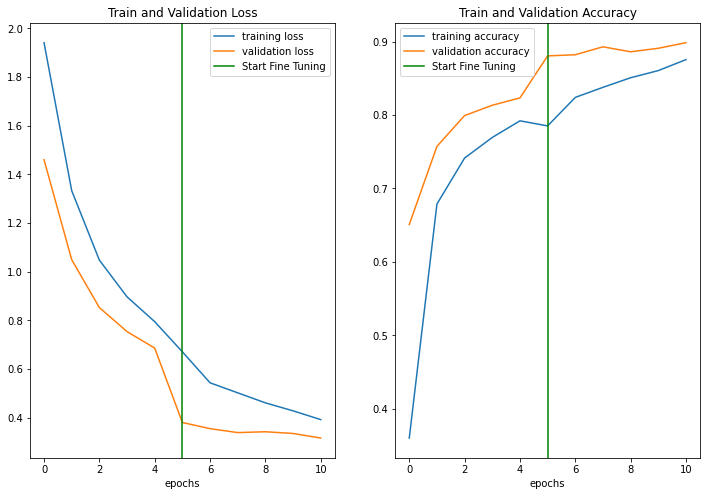

In [214]:
compare_loss_curves(history_2 , history_4 , 5)

### 7.0 Comparing Model Using Tensorboard Dev
___

* [Format to upload to tensorboard.dev](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb)
* Upload to Tensorboard.dev are publics. Do not upload sensitive data.


In [215]:

# Uploading model into tensorflow board
!tensorboard dev upload --logdir ./save_dir \
  --name "Transfer Learning" \
  --description "Fine Tuning Featured Extraction with 1% , 10% , 100% Dataset" \
  --one_shot

[2021-09-08T14:27:51] Total uploaded: 360 scalars, 0 tensors, 17 binary objects (13.6 MB)
[2021-09-08T14:27:51] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/lIzyjax4QlWHVjjIKb5JZg/


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/lIzyjax4QlWHVjjIKb5JZg/

In [218]:
#Checking what Tensorboard Experiment one have
!tensorboard dev list

2021-09-08 14:44:59.192874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 14:44:59.201782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 14:44:59.202391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/lIzyjax4QlWHVjjIKb5JZg/
	Name                 Transfer Learning
	Description          Fine Tuning Featured Extraction with 1% , 10% , 100% Dataset
	Id                   lIzyjax4QlWHVjjIKb5JZg
	Created              2021-09-08 14:27:17 (17 minutes ago)
	Updated              2021-09-08 14:27:51 (17 minutes 

In [220]:
# # Delete experiment
# !tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID_HERE

# # Recheck the deletion by checking on tensorboard dev list
# !tensorboard dev list

Sample Extract for Model Accuracy and loss for Fine Tuning Feature Extraction

|Experiment|Data|Preprocessing|Model|
|---|---|---|---|
|Model 0|10 classes of Food101 data at 10%| None|Feature Extractor : EfficientNet B0|
|Model 1|10 classes of Food101 data at 1%|Random Flip, Rotation n, Augmentation|EfficientNetB0|
|Model 2|Same as Model 0|Same as Model 1|EfficientNetB0|
|Model 3|Same as Model 0|Same as Model 1| Fine tuning: EfficientNetB0 with top layers trained on custom data , top 10 layers unfrozen|
|Model 4|10 classes of Food101 data at 100%| Same as Model 1|Same as Model 3|

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/07-tensorboard_accuracy.png'>
<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Neural-Network-with-Tensorflow/main/images/07-tensorboard_loss.png'>